# Final project submission

### Group number: 4
### Student IDs: 46267, 48296, 48297
### Project name: Bank_loans

## Business problem:

We are trying to figure out whether an individual applying for a loan is expected to receive the loan given his background information. 


In case of default of an individual the bank would not receive the loan granted back. Thus, the bank would generate a negtive profit with this specific individual. Moreover, if many individuals default within a short period of time the bank could face serious issues with Bankruns. The model output can create a business value if the bank could verifiy the trustworthiness of a client based on its background information and therefore have less issues with individuals not being able to pay back their loans. This would, however, require the bank to have enough information about existent clients in regards to their background etc.  

## Machine learning problem:
ML Problem: It is a classification problem, since we try to divide the population into two categories, that enables to detect anomalies, meaning (non-) creditworthy creditors when evaluating new clients. 

Target: We use *class* as target since it is the best representation of dividing the creditors into creditworthy and non-creditworthy clients.

<!--TABLE OF CONTENTS-->
## Contents:
- [Data exploration and preparation](#Data)
- [Feature Engineering](#Feature)
  - [Feature Description](#Descr)
  - [Encoding](#Encoding)
  - [Taking a closer look at each feature](#Taking)
  - [Scaling and Splitting the dataset](#Splitting)
- [Model Training](#Model)
  - [Random Forest](#Random)
  - [XGBoost](#XGB)
  - [Logistic Regression](#Logistic)
  - [Nearest Neighbors](#Nearest)
- [Model determination](#Model)
  - [Random Forest](#Random2)
  - [XGBoost](#XGB2)
  - [Logistic Regression](#Logistic2)
  - [Nearest Neighbors](#Nearest2)
- [Model Evaluation](#Test)
  - [Feature Analysis](#Feature2)
- [Neural Networks](#Neural)
- [Bias Audit](#Bias)
- [Final conclusion and remarks](#Conclusion)

#### Import packages

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay 
from sklearn.inspection import permutation_importance
from scikitplot.metrics import plot_cumulative_gain
from pdpbox import pdp, get_dataset, info_plots
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import Sequential, layers, initializers, regularizers, losses, callbacks, optimizers
#from aequitas.group import Group
#from aequitas.bias import Bias
#from aequitas.fairness import Fairness
#from aequitas.plotting import Plot

## Data exploration and preparation <a name="Data"></a>

In [3]:
# Import file
df = pd.read_csv('bank_loans_100k.csv')

# Checking dataset structure
print(f"Number of features:{df.shape[1]}")
print(f"Number of instances:{df.shape[0]}")

Number of features:21
Number of instances:100000


In [4]:
duplicated_rows = df[df.duplicated()]
duplicated_rows # No duplicates found within our dataset

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class


Checking features types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   checking_status         100000 non-null  object 
 1   duration                100000 non-null  float64
 2   credit_history          100000 non-null  object 
 3   purpose                 100000 non-null  object 
 4   credit_amount           100000 non-null  float64
 5   savings_status          100000 non-null  object 
 6   employment              100000 non-null  object 
 7   installment_commitment  100000 non-null  int64  
 8   personal_status         100000 non-null  object 
 9   other_parties           100000 non-null  object 
 10  residence_since         100000 non-null  int64  
 11  property_magnitude      100000 non-null  object 
 12  age                     100000 non-null  float64
 13  other_payment_plans     100000 non-null  object 
 14  housing              

Checking the distribution of numerical values. Duration and credit_amount are slightly left skewed whereas the other variables are slightly right skewed.
Looking at the distribution of duration and credit_amount there is the chance that we have outliers.
We will, however, not remove any outliners as we will scale our data later on in the notebook.

In [6]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,20.890539,3213.171968,2.955870,2.834780,35.608080,1.424040,1.158470
std,12.066117,2792.189516,1.121461,1.104171,11.246885,0.608057,0.365183
min,-0.367414,-5997.669542,1.000000,1.000000,17.463871,1.000000,1.000000
25%,11.964964,1389.439247,2.000000,2.000000,27.164384,1.000000,1.000000
50%,18.104977,2278.939296,3.000000,3.000000,33.115064,1.000000,1.000000
75%,24.926525,3823.169880,4.000000,4.000000,40.936065,2.000000,1.000000
max,73.201640,19664.977900,4.000000,4.000000,83.846943,4.000000,2.000000


Checking the relationship between target variable and the other features.
The feature "class" is going to be our target variable.
A target value of 1 means the creditor should be classified as good(=solvent).
A target value of 0 means the creditor should be classified as bad, and therefore is not elegible to receive the loan.
We will comeback to the relationship between the target and the other variables later on in the notebook after we perfomed the necessary enconding.

In [7]:
df.rename(columns={"class":"target"}, inplace = True)
df["target"].replace(["good", "bad"], [1,0], inplace=True)

df.corr()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,target
duration,1.000000,0.488690,0.080467,-0.000500,-0.015556,-0.004364,0.004287,-0.182992
credit_amount,0.488690,1.000000,-0.218131,0.003322,-0.005810,-0.004667,0.002141,-0.095754
installment_commitment,0.080467,-0.218131,1.000000,0.006750,-0.002819,-0.003383,-0.005926,-0.051135
residence_since,-0.000500,0.003322,0.006750,1.000000,0.106093,-0.002592,-0.000788,0.001211
age,-0.015556,-0.005810,-0.002819,0.106093,1.000000,0.004464,0.038615,0.085454
existing_credits,-0.004364,-0.004667,-0.003383,-0.002592,0.004464,1.000000,0.000641,0.026544
num_dependents,0.004287,0.002141,-0.005926,-0.000788,0.038615,0.000641,1.000000,-0.003380
target,-0.182992,-0.095754,-0.051135,0.001211,0.085454,0.026544,-0.003380,1.000000


Check for missing values

In [8]:
df.isnull().sum() #No missing values

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
target                    0
dtype: int64

## Feature engineering <a name="Feature"></a>

### Feature Description <a name="Descr"></a>

__Job:__  We assume that this feature is related to the monthly income of the creditors (with 0 representing a low paying job). | ordinary category (V0,V1,V2,V3) --> replaced by int in str

__Checking_status:__  We assume it's the amount of the checking account. | ordinary category (V0,V1,V2,V3) --> replaced by int in str

__Credit_history:__ We assume that this feature is to the credit history of the creditor (with 0 representing a bad credit history). | ordinary category (V0,V1,V2,V3,V4) --> replaced by int in str

__Purpose:__ We assume that this feature represents the purpose of the loan (house loan, car loan ...) | (V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10) --> replaced by one hot encoder (dummies)

__Saving_status:__ We assume that this feature is related to the amount of savings the creditor has (with o representing no savings/little savings). | ordinary category (V0,V1,V2,V3,V4) --> replaced by int in str   


__Employment:__ We assume that this feature is related to i) the type of job the creditor has (unemployed, retired, employed) or ii) the monthly income of the creditor from said job. In the second case, this would mean that this feature would be giving us the same information as the "job" feature. We will check this later in the notebook. | ordinary category (V0,V1,V2,V3,V4) --> replaced by int in str

__Personal_status:__ We assume it describes the personal situation of an individual where the higher the number the more stable the individuals personal situation. | ordinary category (V0,V1,V2,V3,V4) --> replaced by one hot encode (dummies)

__Other_parties:__ We assume it's the amount of parties involved in the loan. | ordinary category (V0,V1,V2) --> replaced by int in str

__Property_magnitude:__ We assume that this feature is related to the amount of property the creditor owns (with 0 representing no property). | ordinary category (V0,V1,V2,V3) --> replaced by int in str

__Other_payment_plans:__ We assume that this feature represents if the creditor has other payments plans(to banks, to stores or no other payment plans). | ordinary category (none, bank, stores) --> ordinary encoder

__Housing:__ We assume that this feature represents i) the type of housing of the creditor (appartment, house...) or possibly if the creditor owns it or its rented. Later in the notebook we will compare this variable with the feature "property_magnitude" because we suspect there may by a potential relationship between these features due to their similar nature. | ordinary category (V0,V1,V2) --> replaced by int in str

__Own_telephone:__ We assume that this feature represents if the creditor has a telephone or not. | binary (none, yes) --> one hot encoder

__Foreign_worker:__ We assume that this feature represents if the creditor is a foreign worker or not. | binary (no, yes) --> one hot encoder

### Encoding <a name="Encoding"></a>

Since a lot of non-numerical features have the string "V" before a numeric value, we will remove the string and then convert the variables to numeric.

In [9]:
for column in df:
    if str(df[column].iloc[0]).startswith('V'):
        df[column] = df[column].str.extract(r'[V](\d)')

Converting all features to numeric.

We will use the pandas method "to_numeric" to  convert all varibales that are anonymized (even though we remove the "V´s"
pandas still considers them categorical).

We first start by transforming these 3 variables below first manually with numeric values, because otherwise we would get NaN values when using the "to_numeric" method (since this features are also categorical).

On the feature "other_payment_plans" we assume that the information relevant to know is if the creditor has any other payments to do. Therefore "banks" and "stores" are represented by the same value.

We encode dummies for the features "purpose" and "personal_status" since, unlike the other features that are ordinal, these represent categorical variables.

In [10]:
df["own_telephone"].replace(["yes", "none"], [1,0], inplace=True)
df["foreign_worker"].replace(["yes", "no"], [1,0], inplace=True)
df["other_payment_plans"].replace(["bank", "stores", "none"], [1,1,0], inplace=True)

features = df[["purpose", "personal_status"]]
df = pd.concat([df, pd.get_dummies(features)], axis=1)
df.drop(columns=["purpose", "personal_status"], inplace=True)

categorical_features = df.select_dtypes(include=[object]).columns
df[categorical_features] = df[categorical_features].apply(pd.to_numeric, errors='coerce', axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   checking_status         100000 non-null  int64  
 1   duration                100000 non-null  float64
 2   credit_history          100000 non-null  int64  
 3   credit_amount           100000 non-null  float64
 4   savings_status          100000 non-null  int64  
 5   employment              100000 non-null  int64  
 6   installment_commitment  100000 non-null  int64  
 7   other_parties           100000 non-null  int64  
 8   residence_since         100000 non-null  int64  
 9   property_magnitude      100000 non-null  int64  
 10  age                     100000 non-null  float64
 11  other_payment_plans     100000 non-null  int64  
 12  housing                 100000 non-null  int64  
 13  existing_credits        100000 non-null  int64  
 14  job                  

### Taking a closer look at each feature <a name="Taking"></a>

First, we start by analyzing the features "employment" and "jobs". 
We assume that these features are related to the monthly income of the creditors (with 0 representing a low paying job), and so these variables maybe be related in some way.

<AxesSubplot:>

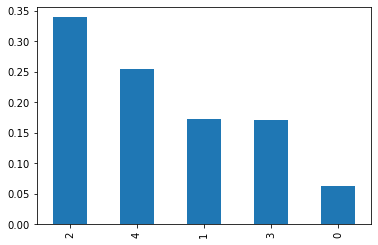

In [12]:
df["employment"].value_counts(normalize=True).plot(kind = 'bar')

<AxesSubplot:>

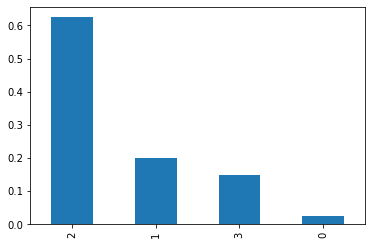

In [13]:
df["job"].value_counts(normalize=True).plot(kind = 'bar')

Looking at the distribution plots we observe that the "middle" values (1, 2 & 3 for "employment" and 1,2 for "job") have the higest amount of samples,which may represent the creditors in the middle class 
(which is typically the class that makes most use of credit).
Despite the fact they assume similar distributions, we decide not to drop any of the two features because their correlation is not strong enough.

In [14]:
print("Correlation:",df["employment"].corr(df["job"]))

Correlation: 0.10029201969011671


Another two features we suspect might be related to each other are "property_magnitude" and "housing". These might both represent the amount of property the creditors have (with 0 being no property/very cheap property).

<AxesSubplot:>

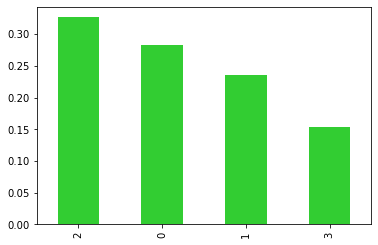

In [15]:
df["property_magnitude"].value_counts(normalize=True).plot(kind = 'bar', color = "limegreen")

<AxesSubplot:>

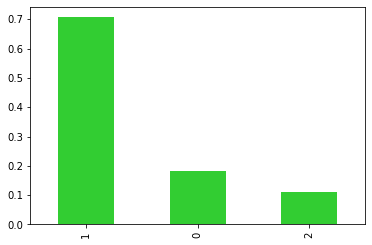

In [16]:
df["housing"].value_counts(normalize=True).plot(kind = 'bar', color = "limegreen")

At first glance it doesn´t seem to exist a big relation between these 2 variables.
After checking the correlation, we decide not to drop any of the features.

In [17]:
print("Correlation:",df["property_magnitude"].corr(df["housing"]))

Correlation: 0.33984285681394244


As to be observed below no compelling correlation exists between any of our features.

Because there are no columns with a high enough correlation to the point where only one column could be kept, no columns were eliminated and we move forward with the df as is. However, later on in the notebook, when applying out models we will incldude  recursive feature elimination and thus figure out whether a dorpping some features would strenghten our model.

<AxesSubplot:>

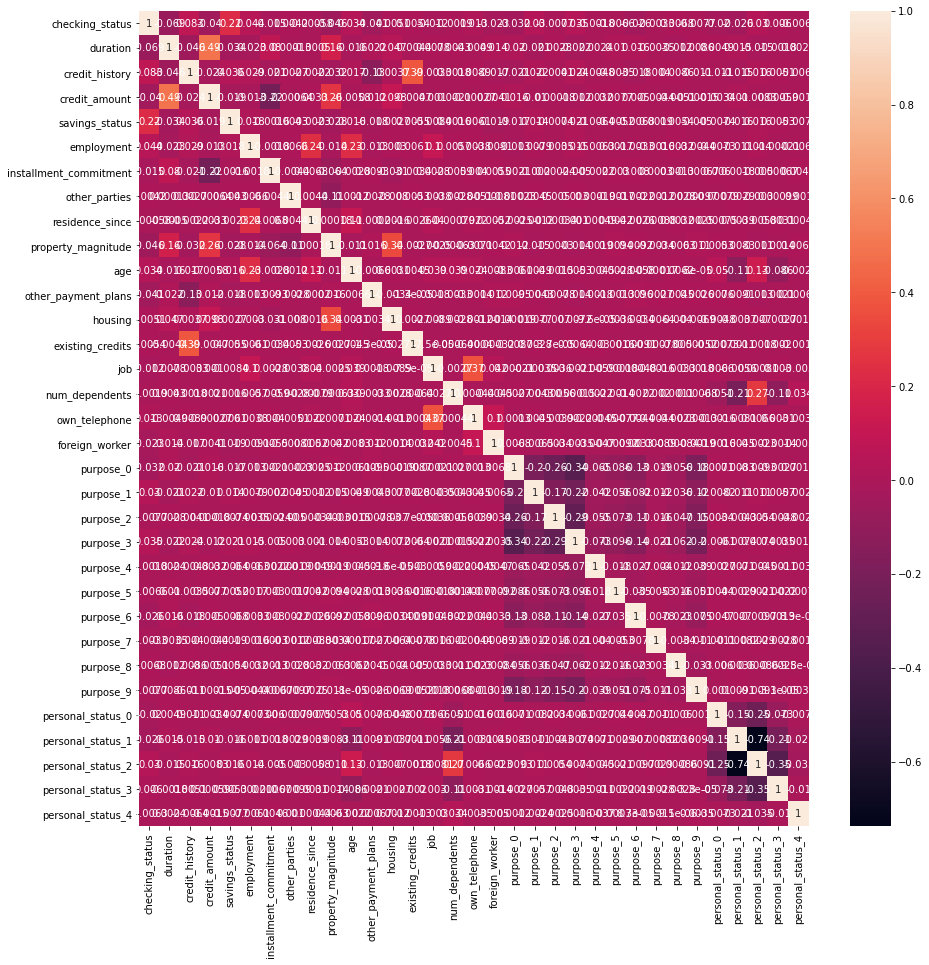

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
corrMatrix=df.drop(columns='target').corr()
sns.heatmap(corrMatrix, annot=True)

### Scaling and Splitting the dataset <a name="Splitting"></a>

In [19]:
X=df.drop(columns='target')
y=df['target']

Checking target distribution.
We have a fairly imbalance dataset. Since we have a big number of observations as it is, we will apply under sampling to randomly remove elements from the majority class.

1    69740
0    30260
Name: target, dtype: int64


<AxesSubplot:>

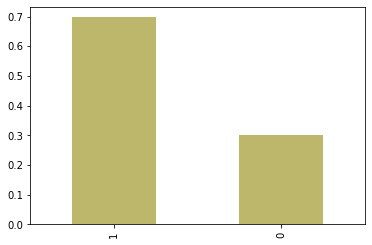

In [20]:
print(y.value_counts())
y.value_counts(normalize = True).plot(kind = 'bar', color = "darkkhaki")

Data Balancing -> Undersampling

0    30260
1    30260
Name: target, dtype: int64


<AxesSubplot:>

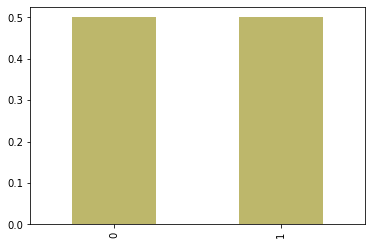

In [21]:
under = RandomUnderSampler(replacement=False ,random_state=0)
X, y = under.fit_resample( X, y)

print(y.value_counts())
y.value_counts(normalize = True).plot(kind = 'bar', color = "darkkhaki") #The dataset is now balanced

Dataset split -> 40% train, 40% validation, 20% test

In [23]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X,y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=42, test_size=0.995)

## Model Training  <a name="Model"></a>

We chose Random Forest as it injects some stochasticity in how the splits are chosen, leading to a more effective "randomness".


XGBoost was chosen because it is an optimized distributed gradient boosting library designed to be highly efficient with often having superior performance compared to other algorithms when applied to structured data.

We decided to apply Logistic Regression as it is easy to understand and it requires less training. 

Nearest neighbours was chosen as it is a popular classifier and there are only two hyperparameter to be tuned.

In all our models we apply RFE with the number of features at a minimum of 15 and a maximum of 34 as this equals the total number of features in our dataset.

RandoizedSearch was chosen over GridSearch as it works more effectively on large datasets.

### Random Forest <a name="Random"></a>

In [24]:
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('RFE', RFE(DecisionTreeClassifier())), 
                 ('classifier', RandomForestClassifier(random_state = 42))])

In [25]:
param_grid = {'classifier': [RandomForestClassifier(random_state = 42)],
              'scaler':[StandardScaler(), MinMaxScaler()],
              'RFE__n_features_to_select': range(15,35,2),
              'classifier__n_estimators': range(100,600,100), 'classifier__max_depth': range(5,11,1)}

random_search_forest = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=5, n_iter=20, scoring='precision') 
random_search_forest.fit(X_train, y_train)
y_pred_forest=random_search_forest.predict(X_val)

### XGBoost <a name="XGB"></a>

In [26]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('RFE', RFE(DecisionTreeClassifier())), 
                 ('classifier', XGBClassifier(random_state = 42))])

In [27]:
param_grid = {'classifier': [XGBClassifier(random_state = 42)],
              'scaler':[StandardScaler(), MinMaxScaler()],
              'RFE__n_features_to_select': range(15,35,2),
              'classifier__eta': [0.001, 0.01, 0.1], 'classifier__max_depth': range(5,11,1)}


random_search_xgb = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=5, n_iter=20, scoring='precision') 
random_search_xgb.fit(X_train, y_train)
y_pred_xgb=random_search_xgb.predict(X_val)

[12:18:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[12:18:24] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[12:18:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[12:18:33] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:33] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:33] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:34] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

### Logistic Regression <a name="Logistic"></a>

We test only L2 regularization as L1 is not supported. Lower values of C were choosen to iterate as it allows for stronger regularization, hence it can enhance our performance on unseen data which is exactly what we try to achive.

In [28]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('RFE', RFE(DecisionTreeClassifier())),
                 ('classifier', LogisticRegression(random_state = 42, penalty = 'l2'))])

In [29]:
param_grid = {'classifier': [LogisticRegression(random_state = 42, penalty = 'l2')],
              'scaler':[StandardScaler(), MinMaxScaler()],
              'RFE__n_features_to_select': range(15,35,2),
              'classifier__C': [0.01,0.1,1]}

random_search_logreg = RandomizedSearchCV(pipe, param_distributions=param_grid, cv = 5, n_iter = 20, scoring='precision')
random_search_logreg.fit(X_train, y_train)
y_pred_logreg=random_search_logreg.predict(X_val)

### Nearest neighbors <a name="Nearest"></a>

In [30]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('RFE', RFE(DecisionTreeClassifier())),
                 ('classifier', KNeighborsClassifier(n_neighbors = ()))])

In [31]:
param_grid = {'classifier': [KNeighborsClassifier(n_neighbors = ())], 
              'scaler':[StandardScaler(), MinMaxScaler()],
              'RFE__n_features_to_select': range(15,35,2),
              'classifier__n_neighbors': range(19, 31,2)}

random_search_kn = RandomizedSearchCV(pipe, param_distributions=param_grid, cv = 5, n_iter = 20, scoring='precision')
random_search_kn.fit(X_train, y_train)
y_pred_kn=random_search_kn.predict(X_val)

## Model determination <a name="Model"></a>

### Random Forest <a name="Random2"></a>

In [32]:
print('Best parameters: ', random_search_forest.best_params_)
print('Precision is', precision_score(y_val, y_pred_forest))
print('F1 score is', f1_score(y_val, y_pred_forest))
print('Recall is', recall_score(y_val, y_pred_forest))

Best parameters:  {'scaler': MinMaxScaler(), 'classifier__n_estimators': 200, 'classifier__max_depth': 9, 'classifier': RandomForestClassifier(max_depth=9, n_estimators=200, random_state=42), 'RFE__n_features_to_select': 23}
Precision is 0.717737081936205
F1 score is 0.7051717948176461
Recall is 0.6930388941928521


### XGBoost <a name="XGB2"></a>

In [33]:
print('Best parameters: ', random_search_xgb.best_params_)
print('Precision is', precision_score(y_val, y_pred_xgb))
print('F1 score is', f1_score(y_val, y_pred_xgb))
print('Recall is', recall_score(y_val, y_pred_xgb))

Best parameters:  {'scaler': MinMaxScaler(), 'classifier__max_depth': 7, 'classifier__eta': 0.01, 'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eta=0.01, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=7,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), 'RFE__n_features_to_select': 15}
Precision is 0.6595997546388591
F1 score is 0.6857997010463378
Recall is 0.7141671163505043


### Logistic Regression <a name="Logistic2"></a>

In [34]:
print('Best parameters: ', random_search_logreg.best_params_)
print('Precision is', precision_score(y_val, y_pred_logreg))
print('F1 score is', f1_score(y_val, y_pred_logreg))
print('Recall is', recall_score(y_val, y_pred_logreg))

Best parameters:  {'scaler': MinMaxScaler(), 'classifier__C': 0.01, 'classifier': LogisticRegression(C=0.01, random_state=42), 'RFE__n_features_to_select': 23}
Precision is 0.7646651761950388
F1 score is 0.670056207290622
Recall is 0.596280768751816


### Nearest neighbors <a name="Nearest2"></a>

In [35]:
print('Best parameters: ', random_search_kn.best_params_)
print('Precision is', precision_score(y_val, y_pred_kn))
print('F1 score is', f1_score(y_val, y_pred_kn))
print('Recall is', recall_score(y_val, y_pred_kn))

Best parameters:  {'scaler': StandardScaler(), 'classifier__n_neighbors': 21, 'classifier': KNeighborsClassifier(n_neighbors=21), 'RFE__n_features_to_select': 21}
Precision is 0.691630540564452
F1 score is 0.6696361650641368
Recall is 0.6489975509526379


As aformentioned it would be more costly for a a bank to give out a loan to a potential defaulter in comparison to not giving out a loan to a good creditor. Thus, in order to achieve a low type II error we need to maximize our precision score and therefore we chose that as our metric to determine the best model. 

Below we computed a function that retrieves the best model based on the above printed outputs. 

In [43]:
models = {
     "randomforest": random_search_forest,
     "xgboost": random_search_xgb,
     "logistic_regression": random_search_logreg,
     "nearest_neighbours": random_search_kn
 }

precision_scores= {
    "random_forest": f1_score(y_val, y_pred_forest),
    "xgboost": f1_score(y_val, y_pred_xgb),
    "logistic_regression": f1_score(y_val, y_pred_logreg),
    "nearest_neighbours": f1_score(y_val, y_pred_kn)
}

In [44]:
f1_score(y_val, y_pred_kn)


0.6696361650641368

In [45]:
def leading_model():
    for a, b in models.items():
        if max(precision_scores, key = precision_scores.get) == a:
            best = b
            
    return best.best_params_

model = leading_model()

UnboundLocalError: local variable 'best' referenced before assignment

## Model Evaluation <a name="Test"></a>

After selecting and tuning our model on the train set, we evaluated its performance on the validation set and apply it to the test set. Based on the precision score we determined that our best model is the XGBoost classifier. 

In [36]:
final_pipe = Pipeline([('scaler', model['scaler']),
                       ('RFE', RFE(DecisionTreeClassifier(), n_features_to_select = model['RFE__n_features_to_select'])), 
                       ('classifier', model['classifier'])])

final_pipe.fit(X_train, y_train)
y_pred_final=final_pipe.predict(X_test)

[03:21:36] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


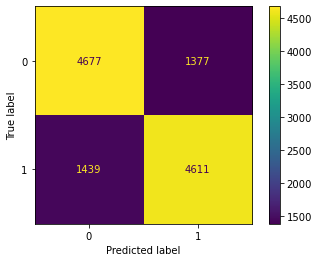

In [37]:
cm=confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(cm).plot()

In [38]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      6054
           1       0.77      0.76      0.77      6050

    accuracy                           0.77     12104
   macro avg       0.77      0.77      0.77     12104
weighted avg       0.77      0.77      0.77     12104



Above we plotted a confusion matrix, the classification report and the ROC-curve. As aformentioned in our business problem the type II error is more costly. Hence, it is important to emphasize the number of false positives. Our model predicted a total of 1377 of creditors that were labeled solvent but in fact were not. 

Tying in to the false positive number we have the precision score. The classification report shows 77% of the creditors that were labeled solvent were in fact creditworthy. Furthermore, our recall score shows that we were able to identify around 78% of the good creditors present in our test set.     

### Feature Analysis <a name="Feature2"></a>

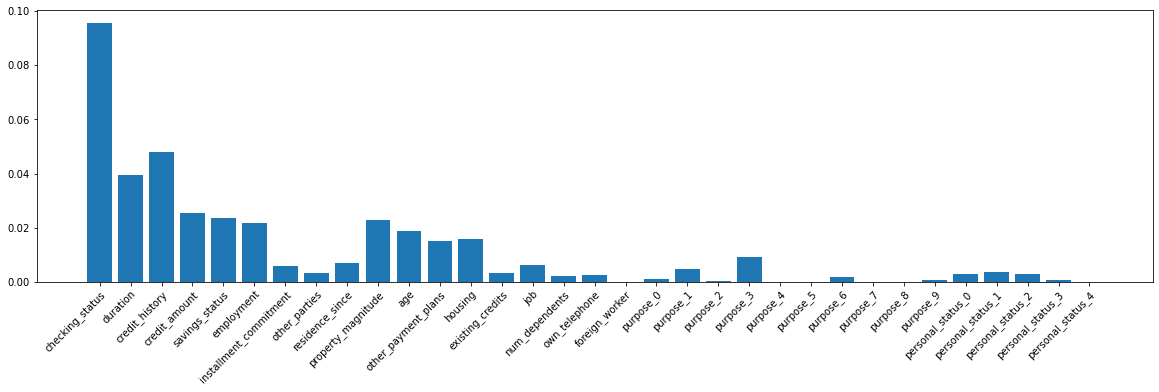

In [39]:
perm_pipe = permutation_importance(final_pipe, X_train, y_train, n_repeats=30, random_state=42)
feat_import_gini = perm_pipe.importances_mean
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(feat_import_gini)), feat_import_gini, align="center")
ax.set(xticks=range(len(feat_import_gini)), xticklabels=X_train.columns)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

Looking at the permutation feature importance plot it can be noticed that checking status and credit history are ammong the most important features of our model. The purpose and personal status dummy features seem at first glance not as important to our model although this could due to the fact that they are correlated with other variables.

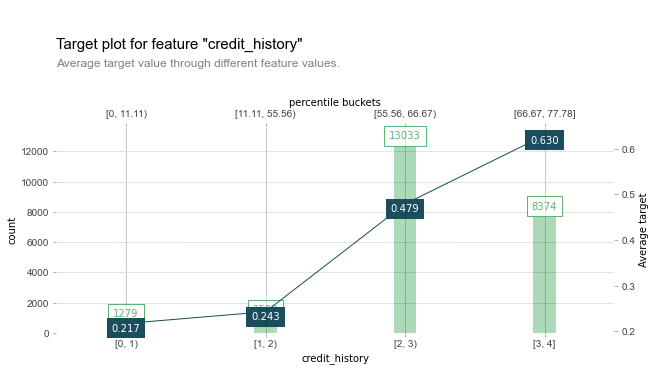

In [40]:
Xy_train=X_train.copy()
Xy_train['target'] = y_train
fig, axes, summary_df = info_plots.target_plot(
df=Xy_train, feature='credit_history', feature_name='credit_history', target='target', show_percentile=True, figsize=(10,6))

Analyzing the credit_history plot we come to a very rational conclusion: a better credit history leads to a bigger probability of the creditor being solvent and therefore belonging to class 1.

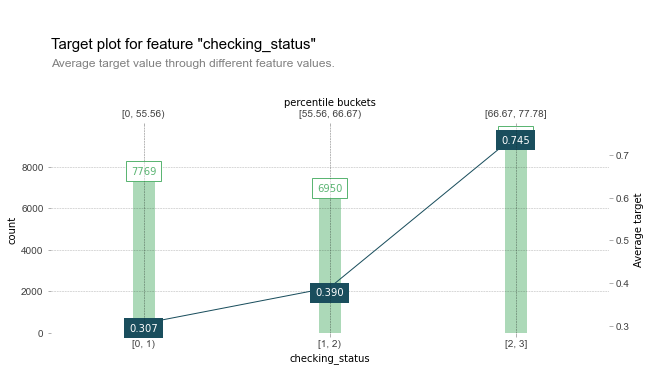

In [41]:
Xy_train=X_train.copy()
Xy_train['target'] = y_train
fig, axes, summary_df = info_plots.target_plot(
df=Xy_train, feature='checking_status', feature_name='checking_status', target='target', show_percentile=True, figsize=(10,6))

The checking status plot also a very logical behaviour as it indicates that a higher value in checking status lead to a higher probability of the creditor belonging to class 1 and thus being classified as solvent

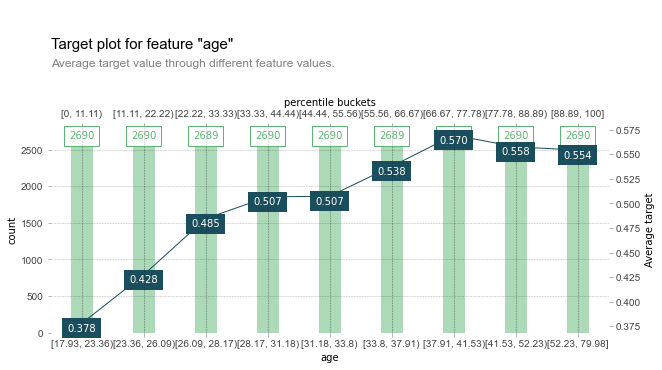

In [42]:
Xy_train=X_train.copy()
Xy_train['target'] = y_train
fig, axes, summary_df = info_plots.target_plot(
df=Xy_train, feature='age', feature_name='age', target='target', show_percentile=True, figsize=(10,6))

From the above plot we conclude that higher values in age generally leads to a bigger probability of the creditor belonging to class 1. This makes sense because, from the point of view of the banks, younger people may not be as stable in terms of their personal and financial situations when compared to more mature people.

However, we dont observe this trend in the last percentile. The most logical explanation for this trend is that, since this percentile starts around the age of 50, the creditors are getting close to retirement status which tipically comes with a loss in monthly income. 

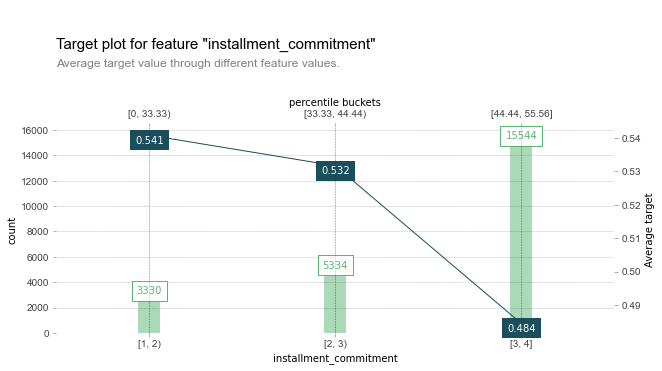

In [43]:
Xy_train=X_train.copy()
Xy_train['target'] = y_train
fig, axes, summary_df = info_plots.target_plot(
df=Xy_train, feature='installment_commitment', feature_name='installment_commitment', target='target', show_percentile=True, figsize=(10,6))

The main takeaway from the installment_commitment plot its an obvious one: the bigger the value of the installment commitment that the creditor has to pay, the less likelihood the person belongs to class 1. This can happen because the bank considered the creditor riskier and so the interest rate to be paid is bigger, or for the fact that the creditor has less capital himself and so has to borrow a bigger amount.

## Neural Networks <a name="Neural"></a>

In terms of the neural networks we will apply keras tuner in order to tune our hyperparameters. As we have a binary classification problem the last layer will apply sigmoid as the activation method. Additionally, we used precision as our evaluation metric due to our business problem and we also implement early stopping to minimize the training time of the neural network.

In our previous model application we scaled the data within the pipeline. Therefore, we scale the data seperately before training the neural network model.

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

In [63]:
initializer = initializers.HeNormal()

def build_model(hp):
  model = Sequential()

  for i in range(hp.Int('num_layers', 1, 4)): 
      model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=34, max_value=136,  step=34), activation='relu',
                                            kernel_initializer=initializer,
                                            kernel_regularizer=regularizers.l2(0.01)))


  model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01)))

  model.compile(
      optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
      loss='binary_crossentropy',
      metrics=[tf.keras.metrics.Precision(name='precision')]
  )

  return model

In [64]:
import keras.metrics
tuner = kt.RandomSearch(
    build_model,
    objective= kt.Objective('val_precision', direction = 'max'),
    max_trials=10,
    project_name='simple_classification',
    overwrite=True   
)

In [65]:
early_stopping_cb = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [66]:
tuner.search(X_train_scaled, y_train, callbacks = [early_stopping_cb], epochs=40, validation_data=(X_val_scaled, y_val))
best_model = tuner.get_best_models()[0]
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

Trial 10 Complete [00h 01m 31s]
val_precision: 0.7644858360290527

Best val_precision So Far: 0.8068408370018005
Total elapsed time: 00h 08m 17s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


{'num_layers': 3,
 'units_0': 136,
 'learning_rate': 0.01,
 'units_1': 68,
 'units_2': 136,
 'units_3': 68}

In [67]:
history = best_model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_val_scaled, y_val))

Epoch 1/10
757/757 [==============================] - 3s 3ms/step - loss: 0.5778 - precision: 0.7426 - val_loss: 0.5855 - val_precision: 0.7077
Epoch 2/10
757/757 [==============================] - 2s 3ms/step - loss: 0.5778 - precision: 0.7409 - val_loss: 0.5803 - val_precision: 0.7313
Epoch 3/10
757/757 [==============================] - 2s 3ms/step - loss: 0.5772 - precision: 0.7391 - val_loss: 0.5821 - val_precision: 0.7731
Epoch 4/10
757/757 [==============================] - 2s 3ms/step - loss: 0.5772 - precision: 0.7444 - val_loss: 0.5847 - val_precision: 0.7019
Epoch 5/10
757/757 [==============================] - 2s 3ms/step - loss: 0.5762 - precision: 0.7426 - val_loss: 0.5770 - val_precision: 0.7684
Epoch 6/10
757/757 [==============================] - 2s 3ms/step - loss: 0.5758 - precision: 0.7429 - val_loss: 0.5848 - val_precision: 0.7773
Epoch 7/10
757/757 [==============================] - 2s 3ms/step - loss: 0.5766 - precision: 0.7402 - val_loss: 0.5761 - val_precision:

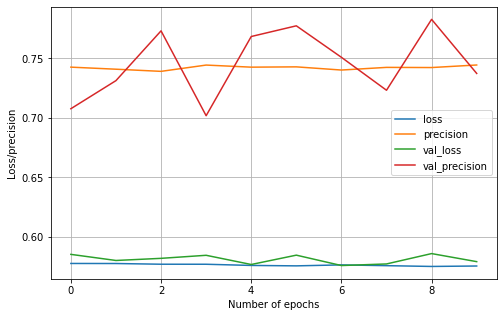

In [68]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Number of epochs')
plt.ylabel('Loss/precision')
plt.show()

From the plot above we can see a positive outcome when it comes to our training loss as well as the validation loss because it slightly decreases over time. 

However, in terms of precision, our training precision remains at a constant level while our validation precision shows a wide range of outputs.

Another important factor to notice is that the precision curves are not that close to each other. This could be a sign of of overfitting. 

## Bias Audit <a name="Bias"></a>

In [53]:
y_test_array = np.array(y_test)

In [54]:
X_test=pd.DataFrame(X_test, columns=X_val.columns)
X_train=pd.DataFrame(X_train, columns=X_train.columns)
aequitas = X_test.filter(items=['foreign_worker'])
aequitas['Foreign_worker'] = aequitas['foreign_worker'].apply(lambda x: "Y" if x == 1 else "N")
aequitas["label_value"] = y_test_array
aequitas["score"] = y_pred_final
df1 = aequitas.drop(columns=['foreign_worker'])
df1.head()

,Foreign_worker,label_value,score
40661,Y,1,1
16866,Y,0,0
40675,Y,1,1
38073,Y,1,1
12758,Y,0,0


In [55]:
g = Group()
xtab, _ = g.get_crosstabs(df1)
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,5988,Foreign_worker,N,0.754579,0.747748,0.446667,0.119658,0.252252,...,0.609375,28,67,83,206,273,111,384,12104,0.710938
1,0,binary 0/1,5988,Foreign_worker,Y,0.762506,0.773010,0.229970,0.234446,0.226990,...,0.490956,1349,1372,4594,4405,5777,5943,11720,12104,0.492918


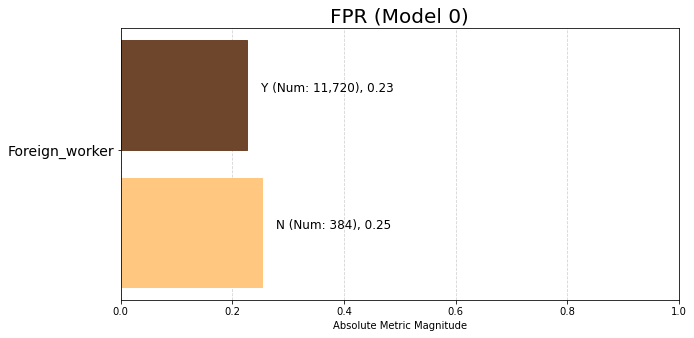

In [56]:
aqp = Plot()
fpr = aqp.plot_group_metric(xtab, 'fpr')

In [57]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=df1, ref_groups_dict={'Foreign_worker':'N'}, alpha=0.05, mask_significance=True)
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)
bdf[['attribute_name', 'attribute_value'] + calculated_disparities + disparity_significance]

get_disparity_predefined_group()


,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,Foreign_worker,N,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Foreign_worker,Y,24.589744,0.805671,0.86961,1.959295,0.514858,0.899852,0.967697,1.010506,1.033785,1.391621


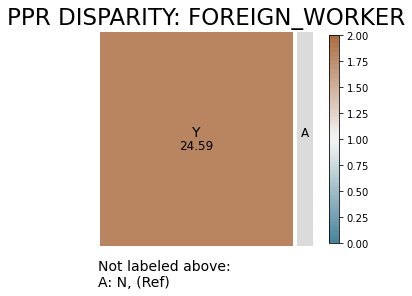

In [58]:
aqp.plot_disparity(bdf, group_metric='ppr_disparity', attribute_name='Foreign_worker', significance_alpha=0.05)

From the bias table and the plot above we observe the disparity ratio (fpr_disparity) and very easy conclude that foreign workers are falsely denied the loan almost 25 times more when compared to non-foreign workers. However, even with eliminating the feature from our dataset we could still be affected by bias as the variable in question could be correlated to other variables in the dataset.

#### Final conclusion and remarks <a name="Conclusion"></a>
In this notebook we implemented different approaches to determine whether a creditor would be solvent or not. As mentioned through our work the type II error was the most costly one and we therefore tried to maximize precision score. In the end the model chosen was the XGBoost classifier which allowed us to identify 77% of the creditors that were actually labeled solvent.

After applying the model we also checked for feature importance and came to the conlusion that checking status and credit history where some of the most important variables in our model. For this features in particular we also looked at how a different range of values has affected our target and deem it to be plausible and rational.

Subsequently, we trained a neural network model on our data. We had mixed results regarding the precision score, however, our loss for the training ad validation data deacreased over the different epochs.

In addition to analysing the metrics we studied whether or not our dataset suffered from potential bias. From the work performed we can easily extract that the feature foreign worker shows sign of strong bias. 